# Convolutional Neural Network

### Part 1 - Building the CNN

#### Importing the Tensorflow libraries and packages

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.4
Scikit-Learn 0.24.1
GPU is available


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import os

In [3]:
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
VALID_DIR = 'dataset/valid'
IMG_SIZE = 224
IMG_RESCALE = 224

##  ResNet50 

In [4]:
import tensorflow.keras as keras

resnet50 = keras.applications.resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False)
conv_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:
import matplotlib.pyplot as plt
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        zoom_range = 0.2,
        horizontal_flip = True
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        TRAIN_DIR,
        target_size = (height, width), 
        batch_size = batch_size,
        class_mode = 'categorical'
    )

    val_dataset = imgdatagen.flow_from_directory(
        VALID_DIR,
        target_size = (height, width), 
        batch_size = batch_size,
        class_mode = 'categorical'
    )
    
    test_dataset = imgdatagen.flow_from_directory(
        TEST_DIR,
        target_size = (height, width), 
        batch_size = batch_size,
        class_mode = 'categorical'
    )
    return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [8]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [9]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)

# final softmax layer with 250 categories
predictions = keras.layers.Dense(250, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
for layer in conv_model.layers:
    layer.trainable = False

In [11]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])

In [13]:
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=4,
    epochs=20,
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1101 steps, validate for 40 steps
Epoch 1/20
1101/1101 [==============================] - 151s 137ms/step - loss: 2.2760 - acc: 0.5277 - val_loss: 0.9707 - val_acc: 0.7472
Epoch 2/20
1101/1101 [==============================] - 144s 130ms/step - loss: 0.7511 - acc: 0.7984 - val_loss: 0.7436 - val_acc: 0.7880
Epoch 3/20
1101/1101 [==============================] - 143s 130ms/step - loss: 0.4939 - acc: 0.8623 - val_loss: 0.6517 - val_acc: 0.8232
Epoch 4/20
1101/1101 [==============================] - 143s 130ms/step - loss: 0.3559 - acc: 0.8981 - val_loss: 0.5054 - val_acc: 0.8552
Epoch 5/20
1101/1101 [==============================] - 144s 131ms/step - loss: 0.2780 - acc: 0.9180 - val_loss: 0.4872 - val_acc: 0.8712
Epoch 6/20
1101/1101 [==============================] - 144s 131ms/step - loss: 0.2366 - acc: 0.9304 - val_loss: 0.5228 - val_acc: 0.8640
Ep

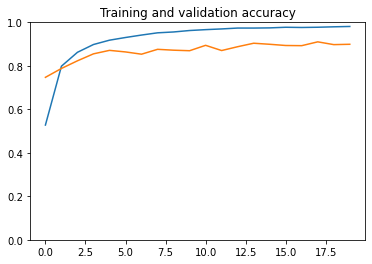

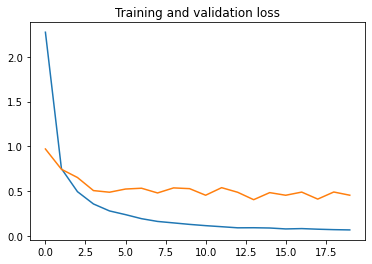

In [14]:
plot_history(history, yrange=(0,1))

In [15]:
score = full_model.evaluate(test_dataset, verbose=0)

print('Test Loss', score[0])
print('Test accuracy', score[1])

  ...
    to  
  ['...']
Test Loss 0.4388900051359087
Test accuracy 0.912
